By :
- Anis Guechtouli
- Anis Benhamdi
- Abderahman Gamgani
- Hamza Bouhouita
- Imad Aliane

In [1]:
import numpy as np
import pandas as pd
import os, cv2
import matplotlib.pyplot as plt

In [2]:
def extract_circles(gray_scale):
    """
    Extracts iris circles from the input grayscale image.

    Args:
    - gray_scale: Grayscale input image.

    Returns:
    - circle_info: Dictionary containing the information of the detected circle.
    - center: Tuple containing the coordinates of the detected circle's center.
    - radius: Integer value representing the detected circle's radius.
    """
    # Initialize dictionary to store circle information
    circle_info = {'center': None, 'radius': None}
    
    # Detect circles using Hough transform
    circles = cv2.HoughCircles(gray_scale, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=50, param2=30, minRadius=260, maxRadius=280)
    
    # If circles are detected
    if circles is not None:
        # Calculate distance of circle centers from the image center
        center_distance = np.sqrt((circles[0,:,0] - gray_scale.shape[1]/2)**2 + 
                                  (circles[0,:,1] - gray_scale.shape[0]/2)**2)
        # Get index of the closest circle
        closest_circle_index = np.argmin(center_distance)
        
        # Extract circle information
        circle = circles[0, closest_circle_index, :]
        center = (int(circle[0]), int(circle[1]))
        radius = int(circle[2])
        
        # Update circle_info dictionary
        circle_info['center'] = center
        circle_info['radius'] = radius
        
        # Visualize detected circle on the input image
        detected_image = cv2.cvtColor(gray_scale, cv2.COLOR_GRAY2BGR)
        cv2.circle(detected_image, center, radius, (0, 255, 0), 2)
        
        # Return circle information
        return circle_info, center, radius
    
    else:
        # If no circle is detected, print a message
        print("No circle detected.")


In [3]:
def preprocessing(raw_image, height, width):
    """
    Preprocesses the raw input image for iris recognition.

    Args:
    - raw_image: Input image.
    - height: Desired height of the resized image.
    - width: Desired width of the resized image.

    Returns:
    - gray_scaled: Preprocessed grayscale image.
    - circle_info: Dictionary containing the information of the detected circle.
    - center: Tuple containing the coordinates of the detected circle's center.
    - radius: Integer value representing the detected circle's radius.
    """
    # Resize the raw image to the specified height and width
    resized_img = cv2.resize(raw_image, (width, height))
    
    # Convert the resized image to grayscale
    gray_scaled = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    
    # Extract circle information using the extract_circles function
    circle_info, center, radius = extract_circles(gray_scaled)
    
    # Create a circular mask based on the detected circle
    mask = np.zeros_like(gray_scaled)
    cv2.circle(mask, center, radius, (255), thickness=-1)
    
    # Apply the mask to the grayscale image
    gray_scaled = cv2.bitwise_and(gray_scaled, gray_scaled, mask=mask)
    
    # Calculate histogram of the masked grayscale image
    hist_image = cv2.calcHist([gray_scaled], [0], None, [256], [0, 256])
    
    # Resize the grayscale image to a fixed size
    gray_scaled = cv2.resize(gray_scaled, (600, 600))
    
    # Apply Gaussian blur to the resized grayscale image
    gray_scaled = cv2.GaussianBlur(gray_scaled, (9, 9), 0)
    
    # Perform histogram equalization
    gray_scaled = cv2.equalizeHist(gray_scaled)
    
    # Apply morphological opening using a kernel
    kernel = np.ones((5,5), np.uint8)
    gray_scaled = cv2.morphologyEx(gray_scaled, cv2.MORPH_OPEN, kernel)
    
    # Return preprocessed grayscale image and circle information
    return gray_scaled, circle_info, center, radius

In [4]:
def point_inside_circle(point, center, radius):
    """
    Checks if a point lies inside a circle.

    Args:
    - point: Tuple containing the (x, y) coordinates of the point.
    - center: Tuple containing the (x, y) coordinates of the circle's center.
    - radius: Integer value representing the circle's radius.

    Returns:
    - inside: Boolean value indicating whether the point lies inside the circle.
    """
    # Calculate the distance between the point and the circle's center
    distance = np.linalg.norm(np.array(point) - np.array(center))
    
    # Check if the distance is less than or equal to the circle's radius
    inside = distance <= radius
    
    # Return whether the point lies inside the circle
    return inside


In [5]:
def sift_extract(gray_scaled, circle_info, center, radius):
    """
    Extracts SIFT keypoints and descriptors from the grayscale image.

    Args:
    - gray_scaled: Preprocessed grayscale image.
    - circle_info: Dictionary containing the information of the detected circle.
    - center: Tuple containing the coordinates of the detected circle's center.
    - radius: Integer value representing the detected circle's radius.

    Returns:
    - keypoints: List of detected SIFT keypoints.
    - descriptors: Array of SIFT descriptors.
    - filtered_keypoints: List of SIFT keypoints lying inside the detected circle.
    - image: Image with SIFT keypoints drawn on it.
    """
    # Create a SIFT object with specified parameters
    sift = cv2.SIFT_create(nfeatures=300, contrastThreshold=0.008, edgeThreshold=10)
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_scaled, None)
    
    # Filter keypoints lying inside the detected circle
    filtered_keypoints = [kp for kp in keypoints if point_inside_circle(kp.pt, center, radius)]
    
    # Draw keypoints on the grayscale image
    image = cv2.drawKeypoints(gray_scaled, filtered_keypoints, None)
    
    # Return keypoints, descriptors, filtered keypoints, and the image with keypoints drawn
    return keypoints, descriptors, filtered_keypoints, image

In [6]:
def parse_filename(filename):
    """
    Parses the filename to extract person ID, eye, and image number.

    Args:
    - filename: String representing the filename.

    Returns:
    - person_id: String representing the person ID.
    - eye: String representing the eye ('R' for right, 'L' for left).
    - image_number: String representing the image number.
    """
    # Remove the file extension
    filename_without_extension = filename.split('.')[0] # 001R_1 instead of 001R_1.png
    
    # Split the filename into two parts based on the underscore
    parts = filename_without_extension.split('_')
    
    # The first part contains the person_id and eye
    person_eye = parts[0]
    person_id = person_eye[:3]  # First three characters are the person_id
    eye = person_eye[3]         # Fourth character is the eye ('R' or 'L')
    
    # The second part is the image number
    image_number = parts[1]
    
    # Return parsed information
    return person_id, eye, image_number

In [29]:
# Function to get features and keypoints
def get_features(df, index):
    row = df.iloc[index]
    features = row['Features']
    keypoints = row['Keypoints']
    return features, keypoints

In [30]:
# Function to compare a specific image's features with dataset images
def compare_features1(df,features1, keypoints1,im):
    results = []

    for index in df.index:

        features2, keypoints2 = get_features(df, index)

        # BFMatcher with default params
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

        # Match descriptors
        matches = bf.match(features1, features2)

        # Calculate matching rate
        matching_rate = len(matches) / min(len(keypoints1), len(keypoints2)) * 100

        results.append({
            'Compare_Index': im,
            'Other_Index': index,
            'Matching_Rate': matching_rate
        })

    return pd.DataFrame(results)

In [13]:
# Function to compare a specific row with all other rows
def compare_features(df, index_to_compare):
    features1, keypoints1 = get_features(df, index_to_compare)
    results = []

    for index in df.index:
        if index != index_to_compare:
            features2, keypoints2 = get_features(df, index)
            
            # BFMatcher with default params
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            
            # Match descriptors
            matches = bf.match(features1, features2)
            
            # Calculate matching rate
            matching_rate = len(matches) / min(len(keypoints1), len(keypoints2)) * 100
            
            results.append({
                'Compare_Index': index_to_compare,
                'Other_Index': index,
                'Matching_Rate': matching_rate
            })

    return pd.DataFrame(results)

In [7]:
# Directory containing iris images
image_dir = "/kaggle/input/extraction/iris_images"

# Initialize variables to store minimum height and width
min_height = float('inf')
min_width = float('inf')

In [8]:
# Initialize variables to store minimum height and width
min_height = float('inf')  # Initialize to positive infinity
min_width = float('inf')   # Initialize to positive infinity

# Iterate through Right and Left subfolders to find minimum height and width
for subdir in os.listdir(image_dir):
    if os.path.isdir(os.path.join(image_dir, subdir)):
        subdir_path = os.path.join(image_dir, subdir)
        for filename in os.listdir(subdir_path):
            if filename.endswith('.png'):
                # Construct full path to the image
                image_path = os.path.join(subdir_path, filename)
                
                # Read the image using OpenCV
                img = cv2.imread(image_path)
                
                # Update minimum height and width if necessary
                min_height = min(min_height, img.shape[0])
                min_width = min(min_width, img.shape[1])

# Print message indicating completion of iteration
print("done")

# Print the minimum height and width
min_height, min_width


done


(576, 768)

In [9]:
# Initialize an empty list to store the rows
rows = []

# Iterate through Right and Left subfolders
for subdir in os.listdir(image_dir):
    if os.path.isdir(os.path.join(image_dir, subdir)):
        subdir_path = os.path.join(image_dir, subdir)
        for filename in os.listdir(subdir_path):
            if filename.endswith('.png'):
                # Parse filename to extract ID, eye, and image number
                person_id, eye, image_number = parse_filename(filename)

                # Load the image
                image_path = os.path.join(subdir_path, filename)
                img = cv2.imread(image_path)

                # Resize the image
                img_resized = cv2.resize(img, (min_width, min_height))

                # Preprocess the image
                gray_scaled, circle_info, center, radius = preprocessing(img_resized, min_height, min_width)

                # Extract features
                keypoints, descriptors, filtered_keypoints, image = sift_extract(gray_scaled, circle_info, center, radius)

                # Append the row to the list
                rows.append({'Person_ID': person_id, 'Eye': eye, 'Image_Number': image_number, 'Features': descriptors,
                            'Keypoints':keypoints,'fk':filtered_keypoints,'img':image})

# Create a dataframe from the list of rows
df = pd.DataFrame(rows)
print("done")

done


In [28]:
df = df.sort_values(by=["Person_ID", "Eye","Image_Number"]).reset_index(drop=True)  # Sort and reset index
df_ni = df.copy()
df_ni = df_ni.drop("img", axis=1)  # Drop the 'img' column
df_ni.head(6)  # Display the first 6 rows

,Person_ID,Eye,Image_Number,Features,Keypoints,fk
0,001,L,1,"[[32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 10...","(< cv2.KeyPoint 0x7a1805280d50>, < cv2.KeyPoin...","[< cv2.KeyPoint 0x7a1805280d50>, < cv2.KeyPoin..."
1,001,L,2,"[[11.0, 17.0, 5.0, 3.0, 1.0, 0.0, 1.0, 9.0, 28...","(< cv2.KeyPoint 0x7a18052f9da0>, < cv2.KeyPoin...","[< cv2.KeyPoint 0x7a18052f9da0>, < cv2.KeyPoin..."
2,001,L,3,"[[12.0, 20.0, 23.0, 0.0, 0.0, 0.0, 34.0, 54.0,...","(< cv2.KeyPoint 0x7a18053d2dc0>, < cv2.KeyPoin...","[< cv2.KeyPoint 0x7a18053d2dc0>, < cv2.KeyPoin..."
3,001,R,1,"[[19.0, 89.0, 74.0, 39.0, 40.0, 6.0, 1.0, 2.0,...","(< cv2.KeyPoint 0x7a18054d3a20>, < cv2.KeyPoin...","[< cv2.KeyPoint 0x7a18054d3a20>, < cv2.KeyPoin..."
4,001,R,2,"[[97.0, 41.0, 0.0, 1.0, 16.0, 2.0, 0.0, 2.0, 5...","(< cv2.KeyPoint 0x7a18054efde0>, < cv2.KeyPoin...","[< cv2.KeyPoint 0x7a18054efde0>, < cv2.KeyPoin..."
5,001,R,3,"[[4.0, 83.0, 68.0, 10.0, 3.0, 0.0, 0.0, 0.0, 0...","(< cv2.KeyPoint 0x7a1806f05da0>, < cv2.KeyPoin...","[< cv2.KeyPoint 0x7a1806f05da0>, < cv2.KeyPoin..."


In [45]:
img_to_find = "/kaggle/input/extraction/iris_images/Left/010L_1.png"
im = os.path.basename(img_to_find)
im = os.path.splitext(im)[0]
img = cv2.imread(img_to_find)
img_resized = cv2.resize(img, (min_width, min_height))
gray_scaled, circle_info, center, radius = preprocessing(img_resized, min_height, min_width)
keypoints, features, filtered_keypoints, image = sift_extract(gray_scaled, circle_info, center, radius)
comparison_results = compare_features1(df,features, keypoints,im)
comparison_results = comparison_results[comparison_results["Matching_Rate"]<100]
comparison_results = comparison_results.sort_values(by="Matching_Rate", ascending=False).head(2)
fox = comparison_results['Other_Index'].iloc[0]
Pers = df_ni.iloc[fox]['Person_ID']
E = df_ni.iloc[fox]['Eye']
MR = comparison_results.iloc[0]['Matching_Rate']
print(f'Hello {Pers}, Eye: {E}, Matching: {MR: .2f}%')
comparison_results

Hello 010, Eye: L, Matching:  68.33%


,Compare_Index,Other_Index,Matching_Rate
55,010L_1,55,68.333333
56,010L_1,56,64.000000


In [22]:
# Define the index to compare
index_to_compare = 200

# Compare features for the given index
comparison_results = compare_features(df_ni, index_to_compare)

# Sort comparison results by Matching_Rate in descending order and select top results
comparison_results = comparison_results.sort_values(by="Matching_Rate", ascending=False).head()

# Get the index of the best matching feature
fox = comparison_results['Other_Index'].iloc[0]

# Extract person ID and eye information from the dataframe
Pers = df_ni.iloc[fox]['Person_ID']
E = df_ni.iloc[fox]['Eye']

# Extract the matching rate from the comparison results
MR = comparison_results.iloc[0]['Matching_Rate']

# Print the result message
print(f'Hello {Pers}, Eye: {E}, Matching: {MR: .2f}%')

Hello 034, Eye: L, Matching:  69.33%


In [19]:
oi = comparison_results['Other_Index'].iloc[0]
comparison_results

,Compare_Index,Other_Index,Matching_Rate
6,002L_3,6,63.000000
7,002L_3,7,61.333333
48,002L_3,48,44.000000
43,002L_3,43,43.666667
0,002L_3,0,43.333333


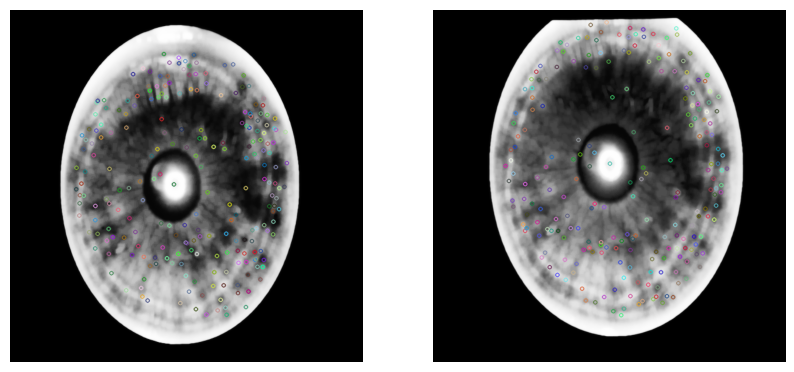

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(df["img"].iloc[oi])
plt.axis('off')

plt.show()